In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import importlib
import dataset
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
importlib.reload(dataset)

<module 'dataset' from '/Users/kjwdamme/Master/DataScience/Data-Science/CIRI/dataset.py'>

In [3]:
transform = transforms.Compose([
    # to-tensor
    transforms.ToTensor(),
    # resize
    transforms.Resize(128),
    # center-crop
    transforms.CenterCrop(128),
    # normalize
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
incidents = dataset.IncidentsDataset("Incidents-subset", transform=transform)

In [5]:
train_indices, test_val_indices, _, _ = train_test_split(range(incidents.__len__()), incidents.targets, stratify=incidents.targets, test_size=.2)

test_indices, val_indices, _, _ = train_test_split(test_val_indices, incidents.targets[test_val_indices], stratify=incidents.targets[test_val_indices], test_size=.5)

In [6]:
len(train_indices), len(test_indices), len(val_indices), incidents.__len__()

(5541, 693, 693, 6927)

In [7]:
train_split = Subset(incidents, train_indices)
val_split = Subset(incidents, val_indices)
test_split = Subset(incidents, test_indices)

train_loader = DataLoader(train_split, batch_size=4, shuffle=True)
val_loader = DataLoader(val_split, batch_size=4)
test_loader = DataLoader(test_split, batch_size=4)

dataloaders = {'train': train_loader, 'test': test_loader, 'val': val_loader}

In [8]:
dataloader = DataLoader(incidents, batch_size=4, shuffle=True)

In [9]:
nSamples = incidents.__len__()
nClasses = len(incidents.labels)
imgShape = incidents.__getitem__(0)[0].shape

print("Number of samples: ", nSamples)
print("Number of classes: ", nClasses)
print("Shape of an image: ", imgShape)

Number of samples:  6927
Number of classes:  12
Shape of an image:  torch.Size([3, 128, 128])


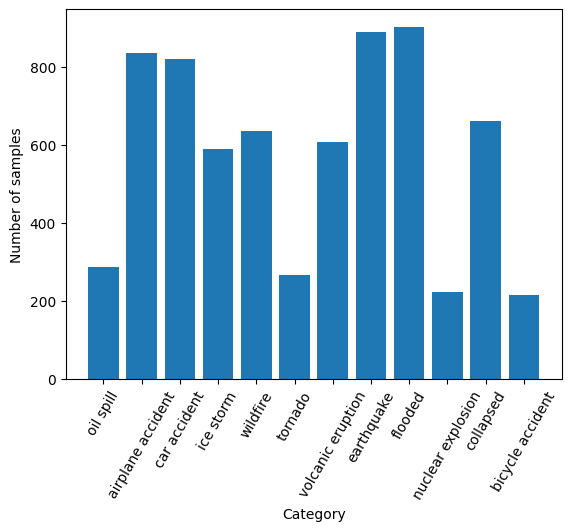

In [10]:
target, counts = np.unique(incidents.targets, return_counts=True)

_, ax = plt.subplots()

ax.bar(incidents.labels[target], counts) #, width=1, edgecolor="white", linewidth=.7)
plt.ylabel("Number of samples")
plt.xlabel("Category")
plt.xticks(rotation=60)
plt.show()

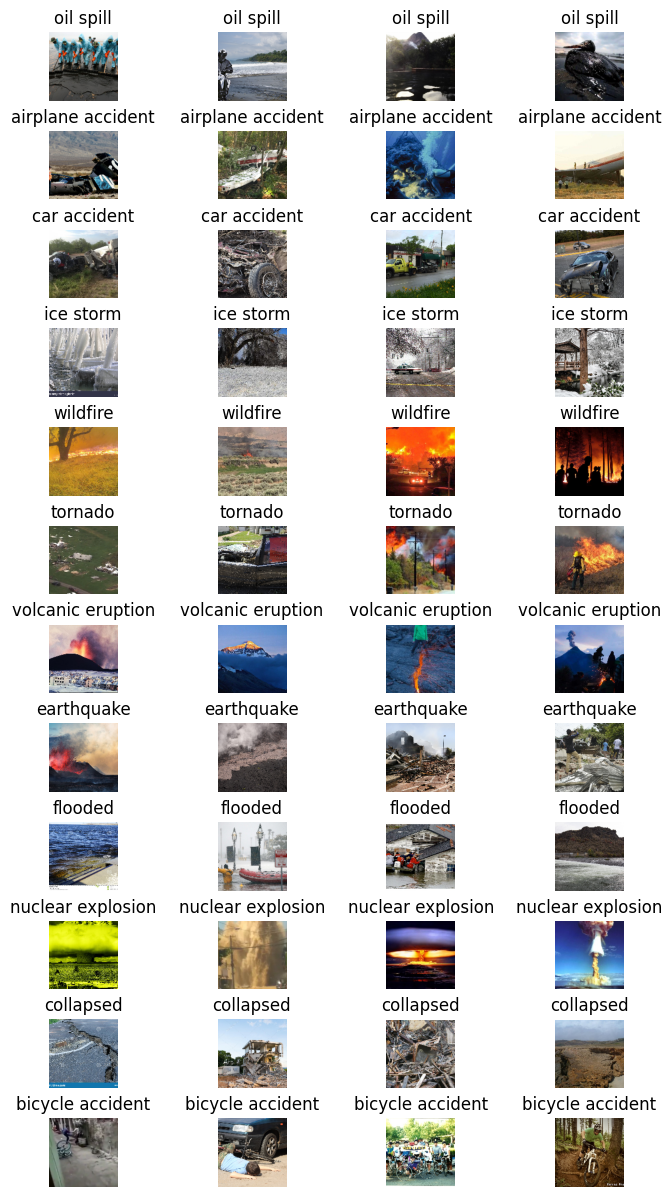

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(nClasses, 4), axes_pad=(1, .3))

images = []

for n in np.arange(nClasses):
    for i in range(4):
        img = incidents.get_item_with_target(n, i)
        idx = n*4+i
        grid[idx].imshow(img.permute(1, 2, 0))
        grid[idx].set_title(incidents.labels[n])
        grid[idx].axis('off')

In [15]:
import time
import copy

def train_model(model, train_loader, validation_loader, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataloaders = {'train': train_loader, 'val': validation_loader}
    acc_history = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train(phase == 'train')

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            acc_history[phase].append(epoch_acc)
            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, time_elapsed, loss_history, acc_history

In [16]:
def accuracy_metric(actual, predicted):
    corr = np.sum(actual == predicted)

    return corr/len(actual)

In [26]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = model.to(device)
model.fc = nn.Linear(2048, nClasses)
optimizer = optim.SGD(model.parameters(), lr=.001, momentum=.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

In [27]:
from sklearn.model_selection import KFold

n_splits = 5

kf = KFold(n_splits, shuffle=True)

models = []
losses = []
accuracies = []

for train_idx, test_idx in kf.split(incidents):
    train_split = Subset(incidents, train_idx)
    test_split = Subset(incidents, test_idx)

    train_loader = DataLoader(train_split, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_split, batch_size=4)

    model, time_elapsed, loss_history, acc_history = train_model(model, train_loader, test_loader, 5)
    models.append(model)
    losses.append(loss_history)
    accuracies.append(acc_history)

Epoch 1/5
----------


KeyboardInterrupt: 